# <center>Audio Emotion Recognition</center>
## <center>Part 3 - Baseline model</center>
#### <center> 24th August 2019 </center> 
#####  <center> Eu Jin Lok </center> 

## Introduction 
Continuing where we left off in [Part 1](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data) and [Part 2](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-2-feature-extra), here we'll build a baseline model for an emotion classifier. When I say baseline, I mean its the simplest most parsimonious model I can think of. And view points will vary from one data scientist to another, but essentially its a model __NOT__ meant to achieve full accuracy potential. It's just to qucikly test the framework and setup the blueprint for how we go about creating a workable emotion classifier, cause at the moment, we don't know what works and what doesn't. This is a long notebook so this is the agenda below: 

1. [Data preparation and processing](#data)
    * [Data preparation](#preparation)
    * [Data processing](#processing)
2. [Modelling](#modelling)
3. [Model serialisation](#serialise)
4. [Model validation](#validation)
5. [Final thoughts](#final)

Upvote this notebook if you like, and be sure to check out the other parts which are now available:
* [Part 4 | Apply to new audio data](https://www.kaggle.com/ejlok1/audio-emotion-part-4-apply-to-new-audio-data)
* [Part 5 | Data augmentation](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation)

Most importantly, I want to thank the 4 authors for their excellent dataset, without it, writing this notebook could not have been possible. The original source of the dataset links are below:

- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)

In [3]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

<a id="data"></a>
## 1. Data preparation and processing
We saw in [Part 1](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data) and [Part 2](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-2-feature-extra) the way we process the audio file into data and the MFCC features we extracted. We're going to do the same thing here except we process the entirity of the audio files. First up we need the reference file that contains the path to the raw audio files for training.

<a id="preparation"></a>
### Data preparation
Lets pick up the meta-data file which we save in [part 1]("https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data"), we're going to need it here to run a loop over it to read all the audio files spread across the 4 directories. 

In [4]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("c://Users/hp/Documents/Github/signal_processing/testing/Data_path.csv")
ref.head()

,labels,source,path
0,relaxed,Telugu,c://Users/hp/Documents/Github/signal_processin...
1,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...
2,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...
3,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...
4,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...


So we've already seen the shape of an MFCC output for each file, and it's a 2D matrix of the number of bands by time. In order to optimise space and memory, we're going to read each audio file, extract its mean across all MFCC bands by time, and  just keep the extracted features, dropping the entire audio file data. 

In [5]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

265


,feature
0,"[0.88471943, 1.279021, -1.2224425, -0.8701959,..."
1,"[-45.23798, -45.23798, -45.23798, -45.23798, -..."
2,"[-48.85396, -48.85396, -48.85396, -48.85396, -..."
3,"[-47.189026, -47.189026, -47.189026, -47.18902..."
4,"[-43.360622, -43.360622, -43.360622, -43.36062..."


<a id="processing"></a>
### Data processing

Like any good standard data science workflow, data processing is the most important step. Cause garbage in grabage out. So lets start munging the data into a workable format and pad out any issues we find. 

In [6]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,relaxed,Telugu,c://Users/hp/Documents/Github/signal_processin...,0.884719,1.279021,-1.222443,-0.870196,-0.786586,-0.731938,-2.575042,...,-14.554338,-15.825727,-15.413176,-15.960588,-16.165821,-15.377755,-15.759939,-15.835154,-14.876807,-11.882338
1,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...,-45.237980,-45.237980,-45.237980,-45.237980,-45.237980,-45.237980,-45.237980,...,-5.076574,-3.801484,-2.838042,-4.161867,-5.183420,-3.299309,-3.967900,-6.655100,-6.263062,-7.393001
2,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...,-48.853958,-48.853958,-48.853958,-48.853958,-48.853958,-48.853958,-48.853958,...,-22.840078,-23.834774,-22.195238,-20.721189,-21.784542,-23.416414,-24.286800,-23.314512,-22.781506,-24.474354
3,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...,-47.189026,-47.189026,-47.189026,-47.189026,-47.189026,-47.189026,-47.189026,...,-1.843297,-0.730488,0.238287,-1.073920,-2.786622,-3.356445,-2.774207,-2.532763,-2.835872,-1.672564
4,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...,-43.360622,-43.360622,-43.360622,-43.360622,-43.360622,-43.360622,-43.360622,...,3.525261,3.053996,2.632945,3.031410,1.845935,2.048495,1.185180,2.602827,3.014727,5.194274


In [7]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(265, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,relaxed,Telugu,c://Users/hp/Documents/Github/signal_processin...,0.884719,1.279021,-1.222443,-0.870196,-0.786586,-0.731938,-2.575042,...,-14.554338,-15.825727,-15.413176,-15.960588,-16.165821,-15.377755,-15.759939,-15.835154,-14.876807,-11.882338
1,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...,-45.237980,-45.237980,-45.237980,-45.237980,-45.237980,-45.237980,-45.237980,...,-5.076574,-3.801484,-2.838042,-4.161867,-5.183420,-3.299309,-3.967900,-6.655100,-6.263062,-7.393001
2,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...,-48.853958,-48.853958,-48.853958,-48.853958,-48.853958,-48.853958,-48.853958,...,-22.840078,-23.834774,-22.195238,-20.721189,-21.784542,-23.416414,-24.286800,-23.314512,-22.781506,-24.474354
3,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...,-47.189026,-47.189026,-47.189026,-47.189026,-47.189026,-47.189026,-47.189026,...,-1.843297,-0.730488,0.238287,-1.073920,-2.786622,-3.356445,-2.774207,-2.532763,-2.835872,-1.672564
4,sad,Telugu,c://Users/hp/Documents/Github/signal_processin...,-43.360622,-43.360622,-43.360622,-43.360622,-43.360622,-43.360622,-43.360622,...,3.525261,3.053996,2.632945,3.031410,1.845935,2.048495,1.185180,2.602827,3.014727,5.194274


Now that looks alot better. Next step we will split the data into 2 parts, one for training and one for validation. This ensures we measure the model's performance at its true accuracy. 

In [17]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.40
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
251,-50.797173,-50.797173,-50.797173,-50.797173,-50.797173,-50.797173,-50.797173,-50.797173,-50.797173,-50.797173,...,-6.682194,-6.327243,-6.198954,-7.053342,-6.535278,-6.938339,-7.167941,-6.815003,-6.129291,-7.534946
63,-23.842131,-18.387299,-14.597189,-9.540781,-5.777290,-4.005803,-2.095940,-1.645171,-1.117436,-0.680841,...,-14.696295,-15.135401,-14.330137,-14.912971,-17.164368,-15.155027,-13.727053,-13.684693,-15.327595,-17.485640
54,-17.195293,-18.963264,-16.725670,-14.458022,-18.917229,-23.375288,-23.067141,-23.946623,-25.138268,-26.843571,...,-28.689741,-23.634653,-15.005502,-14.158456,-14.459838,-15.639968,-17.755135,-19.598604,-16.765362,-11.216659
107,-45.325684,-45.325684,-45.325684,-45.325684,-45.325684,-45.325684,-45.325684,-45.325684,-45.325684,-45.325684,...,-15.303496,-14.608830,-13.489714,-12.123165,-15.140902,-16.191654,-14.678735,-11.182322,-6.869537,-3.222136
50,-16.380421,-6.963007,-3.880233,-4.266044,-4.937781,-5.362973,-5.026975,-5.286244,-4.956858,-4.424677,...,-4.567774,-5.202508,-6.241746,-7.387736,-7.724240,-6.899628,-7.673073,-7.000517,-7.001231,-8.561672
224,-47.481087,-47.481087,-47.481087,-47.481087,-47.481087,-47.481087,-47.481087,-47.481087,-47.481087,-47.481087,...,-6.453059,-7.783837,-8.206168,-8.717319,-7.864048,-8.242949,-8.725077,-9.135363,-6.230384,-1.767862
174,-48.566696,-48.566696,-48.566696,-48.566696,-48.566696,-48.566696,-48.566696,-48.566696,-48.566696,-48.566696,...,-8.917403,-10.760982,-11.495657,-11.147968,-11.946371,-12.441489,-11.843505,-11.483755,-10.665751,-8.880925
225,-48.122055,-47.994240,-47.808281,-47.905937,-47.673210,-47.752640,-48.016228,-47.873169,-47.899899,-47.904305,...,-3.739147,-2.708411,-2.073226,-3.105387,-3.324010,-1.964608,-0.920925,-0.418290,-1.353068,-2.625673
189,-46.566483,-46.566483,-46.566483,-46.566483,-46.566483,-46.566483,-46.566483,-46.566483,-46.566483,-46.566483,...,-1.487239,-2.429646,-2.396287,-2.861350,-3.343908,-5.663990,-8.046372,-12.826021,-17.123362,-16.237917
14,0.396569,-0.720648,-2.298203,-1.130501,-0.424184,-0.214133,0.362438,0.242573,0.103718,0.790704,...,3.402730,3.006891,2.967190,4.031725,2.326749,3.121902,3.558486,3.349815,4.798877,4.916873


Now because we are mixing up a few different data sources, it would be wise to normalise the data. This is proven to improve the accuracy and speed up the training process. Prior to the discovery of this solution in the embrionic years of neural network, the problem used to be know as "exploding gradients". 

In [18]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
251,-0.951252,-0.961978,-0.935501,-0.941874,-0.953030,-0.972997,-1.014979,-1.027698,-1.033178,-1.053015,...,0.471439,0.508403,0.518873,0.448440,0.475302,0.448889,0.444534,0.492162,0.452638,0.162809
63,0.312599,0.549755,0.823070,1.054010,1.238275,1.318651,1.388852,1.364156,1.372836,1.382556,...,-0.120247,-0.143750,-0.083552,-0.144648,-0.333673,-0.174033,-0.051570,-0.024829,-0.323853,-0.752160
54,0.624252,0.522889,0.719669,0.816125,0.598700,0.370014,0.353740,0.278914,0.209495,0.111090,...,-1.153391,-0.773031,-0.133589,-0.087712,-0.127832,-0.210797,-0.356238,-0.469891,-0.445224,-0.175726
107,-0.694708,-0.706765,-0.669700,-0.677176,-0.686710,-0.705026,-0.744913,-0.761443,-0.768191,-0.787110,...,-0.165077,-0.104762,-0.021287,0.065871,-0.179668,-0.252622,-0.123552,0.163492,0.390149,0.559373
50,0.662459,1.082632,1.343692,1.309188,1.279137,1.252183,1.244179,1.186973,1.186891,1.200611,...,0.627547,0.591678,0.515703,0.423206,0.384811,0.451824,0.406328,0.478201,0.379032,0.068401
224,-0.795769,-0.807302,-0.774408,-0.781450,-0.791622,-0.810589,-0.851301,-0.866330,-0.872578,-0.891859,...,0.488356,0.400558,0.370162,0.322876,0.374170,0.349984,0.326759,0.317539,0.444104,0.693093
174,-0.846671,-0.857940,-0.827146,-0.833969,-0.844463,-0.863757,-0.904886,-0.919158,-0.925155,-0.944617,...,0.306412,0.180131,0.126449,0.139459,0.063466,0.031685,0.090894,0.140807,0.069685,0.039046
225,-0.825823,-0.831238,-0.790302,-0.802003,-0.800973,-0.823888,-0.877715,-0.885409,-0.892861,-0.912426,...,0.688725,0.776340,0.824542,0.746352,0.719710,0.825957,0.917034,0.973559,0.855831,0.614218
189,-0.752886,-0.764641,-0.729977,-0.737203,-0.747104,-0.765795,-0.806158,-0.821823,-0.828283,-0.847410,...,0.854985,0.796980,0.800607,0.764767,0.718195,0.545500,0.378093,0.039792,-0.475446,-0.637432
14,1.449088,1.373802,1.420546,1.460878,1.498833,1.504352,1.510194,1.456018,1.431977,1.454070,...,1.216015,1.199499,1.197978,1.284919,1.149786,1.211574,1.255838,1.257134,1.375159,1.307757


For the sake of documentation, I'll just mention here that there's another method for normalisation but it hasn't worked out well, at least not when I implemented it. So I swapped in for something more simple, which is what i've implemented above. Perhaps someone else could give it a try below

```python
max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

X_train[150:160]
```

Next part we'll need to convert the data format to a numpy array, because we are using keras. Initially I had plans to use XGboost or LightGBM for this task. But since I've potential plans to move to a 2D CNN, it may make sense to continue on the Deep Learning path way and implement a ID CNN.

In [19]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(198, 216)
['excited' 'happy' 'relaxed' 'sad']


-------------------
Now because we are using a CNN, we need to specify the 3rd dimension, which for us is 1. Its 1 because we're doing a 1D CNN and not a 2D CNN. If we use the MFCC data in its entirity, we could feed that through as the input data, thus making the network a 2D CNN.  

In [20]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(198, 216, 1)

<a id="modelling"></a>
## 2. Modelling
The architecture of the model below is based on a few sources that I've seen before such as Kaggle and Stackoverflow. I'm unable to find the source but safe to say this particular format works quite well and is fast, although I've used GPU. 

In [22]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 216, 256)          2304      
                                                                 
 activation_9 (Activation)   (None, 216, 256)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 batch_normalization_2 (Batc  (None, 216, 256)         1024      
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 216, 256)          0         
                                                                 
 dropout_2 (Dropout)         (None, 216, 256)          0         
                                                      

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [79]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
13/13 [==============================] - 8s 272ms/step - loss: 0.0128 - accuracy: 0.9949 - val_loss: 2.3141 - val_accuracy: 0.3433
Epoch 2/100
13/13 [==============================] - 3s 216ms/step - loss: 0.0212 - accuracy: 0.9949 - val_loss: 2.3467 - val_accuracy: 0.3433
Epoch 3/100
13/13 [==============================] - 3s 194ms/step - loss: 0.0207 - accuracy: 0.9949 - val_loss: 2.4117 - val_accuracy: 0.3284
Epoch 4/100
13/13 [==============================] - 3s 204ms/step - loss: 0.0241 - accuracy: 0.9899 - val_loss: 2.2835 - val_accuracy: 0.3134
Epoch 5/100
13/13 [==============================] - 3s 195ms/step - loss: 0.0178 - accuracy: 0.9899 - val_loss: 2.2968 - val_accuracy: 0.3284
Epoch 6/100
13/13 [==============================] - 3s 230ms/step - loss: 0.0221 - accuracy: 0.9949 - val_loss: 2.2501 - val_accuracy: 0.3284
Epoch 7/100
13/13 [==============================] - 2s 192ms/step - loss: 0.0133 - accuracy: 0.9949 - val_loss: 2.2698 - val_accuracy: 0.3433

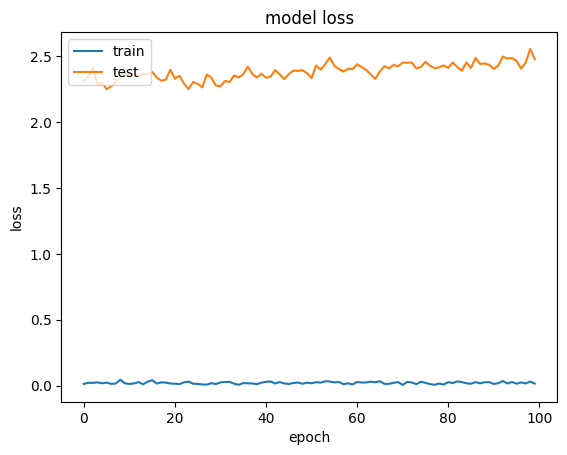

In [80]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So we can see that the loss starts to plateau now at around 50 epochs. Regardless we'll keep it at 100 as the final model.

<a id="serialise"></a>
## 3. Model serialisation
So its time to serialise the model for re-usability. Serialisation and saving mean the same thing. We need to serialise the model architecture and the weights, thats all. 

In [61]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at c:\Users\hp\Documents\GitHub\signal_processing\testing\saved_models\Emotion_Model.h5 


<a id="validation"></a>
## 4. Model validation
Now predicting emotions on the test data. After serialising the model above, i'm going to just reload it into disk. Essentially to re-use the model without having to retrain by re-running the code, we just need to run this section of the code and apply the model to a new dataset. Since we used the same test set in the keras model, the result is essentially the same as the last epoch of 100 which is 43.80%

In [62]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


accuracy: 34.33%


In [63]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

5/5 [==============================] - 0s 31ms/step


array([2, 3, 1, 1, 0, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 2, 1, 3, 3, 1, 0, 0, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 0,
       3, 0, 0, 3, 0, 2, 2, 1, 3, 3, 0, 3, 3, 3, 3, 2, 1, 2, 0, 3, 1, 3,
       2], dtype=int64)

The prediction is in the form of numbers, we'll need to append the labels to it before we run the accuracy measure...

In [64]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues


Lets write the predictions out into a file for re-use

In [65]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
excited,11
happy,11
relaxed,8
sad,37


So, we've made our predictions, so how well have we done? We're going to use the most simplest form of accuracy measure which is absolute accuracy, which is really just the % of records where Actual = Predicted, over the total number of records predicted. We'll also produce the F1, recall and precision scores. 

The most common way to visualise this output is via a confusion matrix. I found an excellent heat map plot to visualise the accuracy of the confusion matrix [here](https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823) which i've borrowed for this notebook

In [66]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


0.34328358208955223


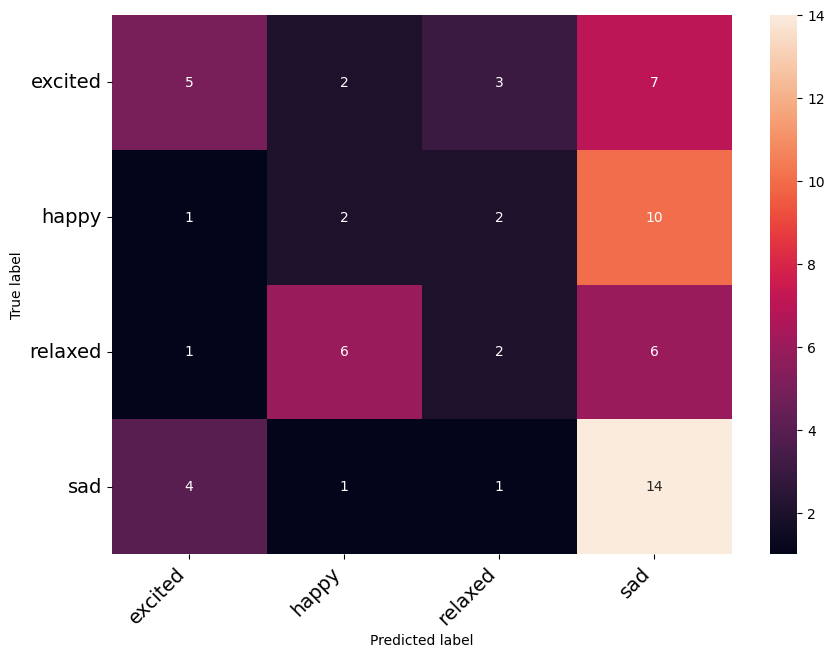

In [67]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [68]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

     excited       0.45      0.29      0.36        17
       happy       0.18      0.13      0.15        15
     relaxed       0.25      0.13      0.17        15
         sad       0.38      0.70      0.49        20

    accuracy                           0.34        67
   macro avg       0.32      0.32      0.29        67
weighted avg       0.32      0.34      0.31        67



#### Emotion accuracy
We'll now ignore the gender part and just super group them into the 7 core emotions. Lets see what we get...

0.34328358208955223


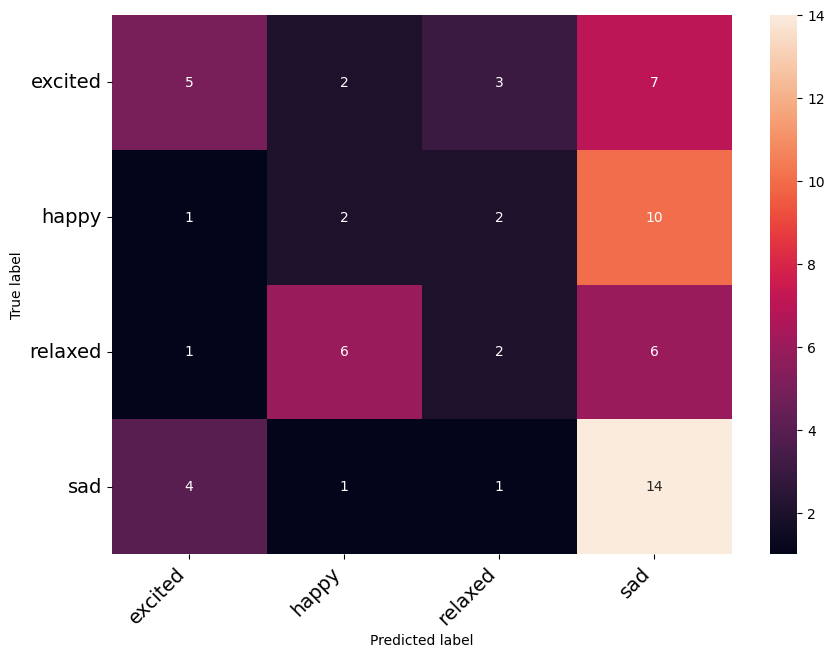

In [69]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'happy':'happy'
                                       , 'sad':'sad'
                                       , 'relaxed':'relaxed'
                                       , 'excited':'excited'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'happy':'happy'
                                       , 'sad':'sad'
                                       , 'relaxed':'relaxed'
                                       , 'excited':'excited'
                                       
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [70]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

     excited       0.45      0.29      0.36        17
       happy       0.18      0.13      0.15        15
     relaxed       0.25      0.13      0.17        15
         sad       0.38      0.70      0.49        20

    accuracy                           0.34        67
   macro avg       0.32      0.32      0.29        67
weighted avg       0.32      0.34      0.31        67

